# Random Forest Regressor (KO)

In this notebook, we delve into the application of the Random Forest Regressor, a powerful ensemble learning algorithm that excels in capturing complex relationships within data.

## Objective

The primary objective of this notebook is to leverage the Random Forest Regressor to predict the 30-day future close price percent change for a selected stock. By harnessing the collective strength of multiple decision trees, the Random Forest Regressor is well-suited for handling intricate patterns and non-linearities present in stock price movements.

In [1]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

import sys
sys.path.append('../src')

from yf_dataset import *
from ta_features import *
from preprocessing import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [2]:
ticker = 'ko'
label = 'KO'
start_date = '2018-01-01'
close_price_period = '1d'
target_pct_change_period = 30 # n = period

In [3]:
ko_df = get_stock_data(ticker, start_date, period=close_price_period)
format_col_names(ko_df)

add_pct_ch_and_future(ko_df, period = target_pct_change_period)
add_sma_rsi_sma_x_rsi(ko_df, [14, 20, 50, 100, 200])
add_ema(ko_df, [14, 20, 50, 100, 200])
add_wma(ko_df, [14, 20, 50, 100, 200])

add_volume_1d_pct_change_sma(ko_df, 10)
add_volume_1d_pct_change_sma(ko_df, 30)
add_volume_1d_pct_change_sma(ko_df, 60)
add_volume_1d_pct_change_sma(ko_df, 90)

ko_df = add_macd_feature(ko_df)
ko_df['Log_Volume'] = ko_df['Volume'].apply(np.log)


ko_df.dropna(inplace=True)
# feature engineering: https://medium.com/aimonks/improving-stock-price-forecasting-by-feature-engineering-8a5d0be2be96

[*********************100%%**********************]  1 of 1 completed


c:\Users\user\Desktop\FMLProject\FML\notebooks\../src\ta_features.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[str(period) + 'd_close_future_pct'] = df[str(period) + 'd_future_close'].pct_change(period) #calc future % change


In [4]:
ko_df

,Open,High,Low,Close,Adj_Close,Volume,30d_close_pct,30d_future_close,30d_close_future_pct,sma14,...,wma200,Volume_1d_change,Volume_10d_change_SMA,Volume_30d_change_SMA,Volume_60d_change_SMA,Volume_90d_change_SMA,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Log_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-17,45.410000,45.990002,45.360001,45.860001,39.234158,11055800,0.019173,42.234734,0.076479,39.149824,...,37.988074,0.058731,0.019847,0.037721,0.048331,0.057523,-0.081496,-0.074594,-0.006902,16.218466
2018-10-18,45.900002,46.080002,45.459999,45.610001,39.020264,12716900,0.004980,43.459179,0.113759,39.114381,...,38.001613,0.150247,0.043978,0.039936,0.041714,0.058134,-0.073852,-0.053560,-0.020292,16.358442
2018-10-19,45.830002,46.490002,45.830002,46.330002,39.636250,13989200,0.021962,42.846951,0.081004,39.120492,...,38.021225,0.100048,0.062834,0.046859,0.050146,0.047786,-0.017884,0.001927,-0.019811,16.453796
2018-10-22,46.369999,46.459999,45.810001,45.970001,39.328255,14283600,0.006535,42.752106,0.087058,39.087493,...,38.037711,0.021045,0.052642,0.052913,0.053332,0.050706,0.001601,0.017129,-0.015528,16.474623
2018-10-23,45.619999,46.459999,45.450001,46.360001,39.661930,17483900,0.015957,42.579639,0.073564,39.117437,...,38.057471,0.224054,0.064685,0.057622,0.059521,0.045436,0.043466,0.047195,-0.003729,16.676791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-12,53.759998,53.830002,52.430000,52.810001,52.810001,19330400,-0.119746,58.570000,0.109070,54.687143,...,59.439933,-0.085553,0.124528,0.149936,0.083822,0.071878,-1.479333,-0.177368,-1.301964,16.777190
2023-10-13,52.740002,53.419998,52.639999,52.889999,52.889999,14494600,-0.108982,58.459999,0.105313,54.393572,...,59.370951,-0.250166,0.101231,0.123196,0.081422,0.070795,-1.485286,-0.146657,-1.338629,16.489287
2023-10-16,53.020000,53.560001,52.840000,53.430000,53.430000,12816800,-0.091993,58.580002,0.096388,54.172143,...,59.307832,-0.115753,0.093548,0.127081,0.077690,0.063544,-1.429946,-0.073054,-1.356892,16.366267


In [5]:
ko_df = add_datetime_features(ko_df,["month", "quarter"])

In [6]:
ko_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma14', 'rsi14',
       'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma50', 'rsi50',
       'SMAxRSI_50', 'sma100', 'rsi100', 'SMAxRSI_100', 'sma200', 'rsi200',
       'SMAxRSI_200', 'ema14', 'ema20', 'ema50', 'ema100', 'ema200', 'wma14',
       'wma20', 'wma50', 'wma100', 'wma200', 'Volume_1d_change',
       'Volume_10d_change_SMA', 'Volume_30d_change_SMA',
       'Volume_60d_change_SMA', 'Volume_90d_change_SMA', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'Log_Volume', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'quarter_1', 'quarter_2',
       'quarter_3'],
      dtype='object')

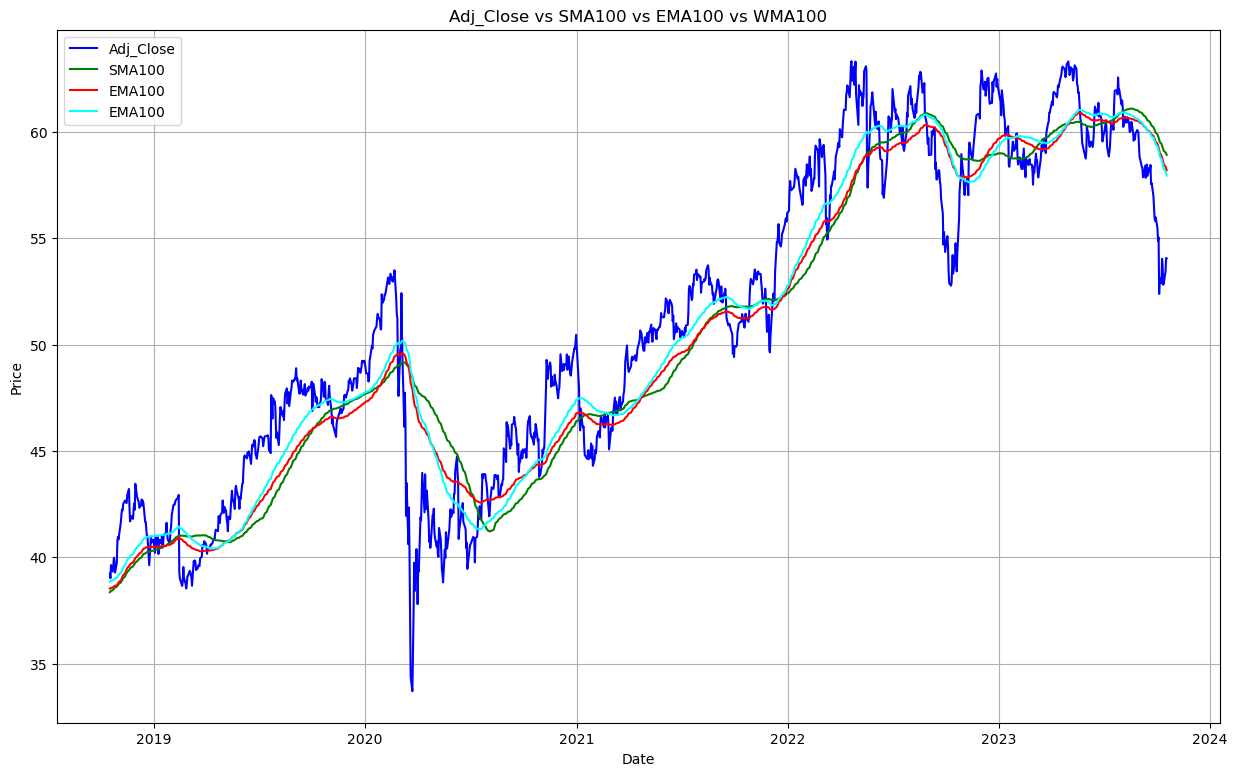

In [7]:
# Plotting
plt.figure(figsize=(15, 9))

# Plot Adj_Close
plt.plot(ko_df['Adj_Close'], label='Adj_Close', color='blue')

# Plot SMA200
plt.plot(ko_df['sma100'], label='SMA100', color='green')

# Plot EMA200
plt.plot(ko_df['ema100'], label='EMA100', color='red')

# Plot EMA200
plt.plot(ko_df['wma100'], label='EMA100', color='cyan')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj_Close vs SMA100 vs EMA100 vs WMA100')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# features, target = split_features_target(ko_df, f'{target_pct_change_period}d_close_future_pct', [f'{target_pct_change_period}d_future_close',f'{target_pct_change_period}d_close_pct', 'Open', 'High', 'Low', 'Close'])
features, target = split_features_target(ko_df, f'{target_pct_change_period}d_close_future_pct', [f'{target_pct_change_period}d_future_close', 'Open', 'High', 'Low', 'Close'])

In [9]:
X = ko_df[features]
y = ko_df[target]

X.shape,y.shape
len(features)

51

In [10]:
# Create a time series split
n_splits = 6
n_samples = X.shape[0]                          
s = n_samples//(n_splits + 1)            

X_train, X_test = X[ :-s], X[-s: ]
y_train, y_test = y[ :-s], y[-s: ]

y_train.shape, y_test.shape

((1080,), (179,))

## Feature Selection Methods

### Mutual Information Feature Selection

Mutual information measures the dependency between variables, highlighting features that provide the most information about the target variable.
- `SelectKBest(mutual_info_regression, k=40)` selects the top 40 features based on mutual information.

### P-value Feature Selection

P-value feature selection relies on statistical testing to identify features that are statistically significant predictors of the target variable.
- `SelectKBest(f_regression, k=40)` selects the top 40 features based on p-values from linear regression.


Both methods aim to enhance model performance by focusing on the most informative features, reducing dimensionality, and potentially mitigating overfitting.

---


In [11]:
# Mutual Information Feature Selection
mi_selector = SelectKBest(mutual_info_regression, k=40)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
selected_features_mi = X.columns[mi_selector.get_support()]

# P-value Feature Selection
f_selector = SelectKBest(f_regression, k=40)
X_train_f = f_selector.fit_transform(X_train, y_train)
selected_features_f = X.columns[f_selector.get_support()]

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be

In [12]:
selected_features_mi

Index(['Adj_Close', '30d_close_pct', 'sma14', 'rsi14', 'SMAxRSI_14', 'sma20',
       'rsi20', 'SMAxRSI_20', 'sma50', 'rsi50', 'SMAxRSI_50', 'sma100',
       'rsi100', 'SMAxRSI_100', 'sma200', 'rsi200', 'SMAxRSI_200', 'ema14',
       'ema20', 'ema50', 'ema100', 'ema200', 'wma14', 'wma20', 'wma50',
       'wma100', 'wma200', 'Volume_10d_change_SMA', 'Volume_30d_change_SMA',
       'Volume_60d_change_SMA', 'Volume_90d_change_SMA', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'month_1', 'month_2', 'month_6',
       'month_9', 'month_11', 'quarter_3'],
      dtype='object')

In [13]:
selected_features_f

Index(['Adj_Close', 'Volume', '30d_close_pct', 'sma14', 'rsi14', 'SMAxRSI_14',
       'sma20', 'rsi20', 'SMAxRSI_20', 'sma50', 'rsi50', 'SMAxRSI_50',
       'sma100', 'rsi100', 'SMAxRSI_100', 'sma200', 'rsi200', 'SMAxRSI_200',
       'ema14', 'ema20', 'ema50', 'ema100', 'ema200', 'wma14', 'wma20',
       'wma50', 'wma100', 'wma200', 'Volume_90d_change_SMA', 'MACD_12_26_9',
       'MACDs_12_26_9', 'Log_Volume', 'month_1', 'month_2', 'month_6',
       'month_7', 'month_9', 'month_10', 'quarter_2', 'quarter_3'],
      dtype='object')

## Common Features Selection

To further refine the feature set, we identify the features that are common to both the Mutual Information and P-value feature selection methods. This step ensures that the selected features exhibit consistency across different criteria for informativeness.


In [14]:
# Obtain the list of features present in both selected_features_mi and selected_features_f
common_features = set(selected_features_mi) & set(selected_features_f)

# Print the common features
print("Common Features:", common_features)

Common Features: {'SMAxRSI_50', 'Volume_90d_change_SMA', 'month_2', '30d_close_pct', 'SMAxRSI_100', 'ema50', 'wma100', 'rsi50', 'SMAxRSI_14', 'sma200', 'rsi100', 'ema200', 'month_1', 'SMAxRSI_200', 'sma14', 'Adj_Close', 'MACDs_12_26_9', 'month_6', 'wma200', 'wma50', 'rsi200', 'wma14', 'sma100', 'month_9', 'ema20', 'ema14', 'rsi20', 'SMAxRSI_20', 'wma20', 'sma20', 'ema100', 'MACD_12_26_9', 'quarter_3', 'rsi14', 'sma50'}


In [15]:
# Convert the set to a list before using it as a column indexer
common_features_list = list(common_features)
len(common_features)


35

In [16]:
X_train = X_train[common_features_list]
X_test = X_test[common_features_list]

In [17]:
# Identify columns to exclude from scaling
exclude_prefixes = ['month_', 'quarter_']
categorical_features = [col for col in common_features if any(col.startswith(prefix) for prefix in exclude_prefixes)]
# Transform to 1s and 0s
X_train[categorical_features] = X_train[categorical_features].astype(int)
X_test[categorical_features] = X_test[categorical_features].astype(int)

In [18]:
X_train.shape

(1080, 35)

## Time Series Split for Model Evaluation

Time Series Split is a cross-validation technique specifically designed for time series data, ensuring temporal order is maintained during training and evaluation. This technique is crucial for accurate model assessment when dealing with time-dependent data.

![Time Series Split](..\images\timeseries.png)

In [20]:
tscv = TimeSeriesSplit(n_splits=n_splits-1)
scaler = StandardScaler()

def smape_score(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    # Check if both y_true and y_pred are 0
    both_zero_mask = (y_true == 0) & (y_pred == 0)
    # If both are 0, set diff to 0 to avoid division by zero
    diff = np.where(both_zero_mask, 0, np.abs(y_true - y_pred) / denominator)
    return 100 * np.mean(diff)

# Define the custom scoring function for RMSE
def rmse_score(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # Negate the RMSE to use as a score

# Make a scorer from the custom RMSE function
rmse_scorer = make_scorer(rmse_score)

# Make a scorer from the custom RMSE function
r2_scorer = make_scorer(r2_score)

explained_var_scorer = make_scorer(explained_variance_score)

# Use make_scorer to create a scorer for GridSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
# Make SMAPE a scorer for scikit-learn
smape_scorer = make_scorer(smape_score, greater_is_better=False)
# Define MAE as a scoring function using make_scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


# Specify multiple scoring metrics, including the custom metric
# scoring = ['r2', 'neg_mean_squared_error', 'explained_variance', smape_scorer, mape_scorer, rmse_scorer, mae_scorer]
scoring = {
    'r2': r2_scorer,
    'explained_variance': explained_var_scorer,
    'sMAPE': smape_scorer,
    'MAPE': mape_scorer
}

# Choose one metric as the refit metric
refit_metric = 'sMAPE'

# Identify columns to scale
features_to_scale = [col for col in common_features if col not in categorical_features]
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
        ('passthrough', 'passthrough', categorical_features)  # This passes through the specified features
    ],
    remainder='drop'  # Drop any columns not explicitly specified
)

# Define the pipeline with a RandomForestRegressor and a StandardScaler
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

param_grid = {
    'rf__n_estimators': [10, 30, 50],
    'rf__max_depth': [5, 15, 20, 40],
    'rf__min_samples_split': [2, 10, 30],
    'rf__min_samples_leaf': [10, 15, 30, 50, 60],
    'rf__max_features': [10, 15, 30],
    # 'feature_selection__threshold': ['mean', 'median']
}

# Perform grid search with cross-validation using R-squared as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=scoring, refit=refit_metric, n_jobs=7)
grid_search.fit(X_train, y_train)

# Access the best parameters and corresponding scores
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Scores:")
# Print the best score for each metric
for metric in scoring.keys():
    key = f'mean_test_{metric}'
    best_score = grid_search.cv_results_[key][grid_search.best_index_]
    print(f"Best mean {metric} Score: {best_score}")

    key = f'std_test_{metric}'
    best_score = grid_search.cv_results_[key][grid_search.best_index_]
    print(f"Best std {metric} Score: {best_score}")

    key = f'rank_test_{metric}'
    best_score = grid_search.cv_results_[key][grid_search.best_index_]
    print(f"Best rank {metric} Score: {best_score}")

best_model = grid_search.best_estimator_

Best Hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 10, 'rf__min_samples_leaf': 50, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}
Best Scores:
Best mean r2 Score: -0.5055419084694958
Best std r2 Score: 0.8952204833766486
Best rank r2 Score: 82
Best mean explained_variance Score: 0.14015672511785152
Best std explained_variance Score: 0.07653190083651859
Best rank explained_variance Score: 51
Best mean sMAPE Score: -62.52859312454534
Best std sMAPE Score: 10.75201222267451
Best rank sMAPE Score: 1
Best mean MAPE Score: -263133750342.13324
Best std MAPE Score: 526267500677.8025
Best rank MAPE Score: 213


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

## Symmetric Mean Absolute Percentage Error (sMAPE) Metric

The Symmetric Mean Absolute Percentage Error (sMAPE) is a metric commonly used to evaluate the accuracy of predictions, especially in forecasting tasks. It measures the percentage difference between the predicted and true values, giving equal importance to both underestimation and overestimation.

### Formula

The sMAPE is calculated using the following formula:

$$
\text{sMAPE} = \frac{1}{N} \sum_{t=1}^{N} \frac{\left| y_t - \hat{y}_t \right|}{\left(\left| y_t \right| + \left| \hat{y}_t \right|\right)} \times 100
$$

where:
- \( N \) is the number of observations.
- \( y_t \) is the true value at time \( t \).
- \( \hat{y}_t \) is the predicted value at time \( t \).

### Implementation

In the provided Python code:

```python
def smape_score(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    both_zero_mask = (y_true == 0) & (y_pred == 0)
    diff = np.where(both_zero_mask, 0, np.abs(y_true - y_pred) / denominator)
    return 100 * np.mean(diff)


In [22]:
y_pred = best_model.predict(X_test)

score = -scoring[refit_metric](best_model, X_test, y_test)
print(f'{refit_metric}: ', score)

# SMAPE: Interpretation: Similar to MAPE but symmetrically accounts for both underestimation and overestimation. It is less sensitive to outliers.
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

sMAPE:  44.985080504874645


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

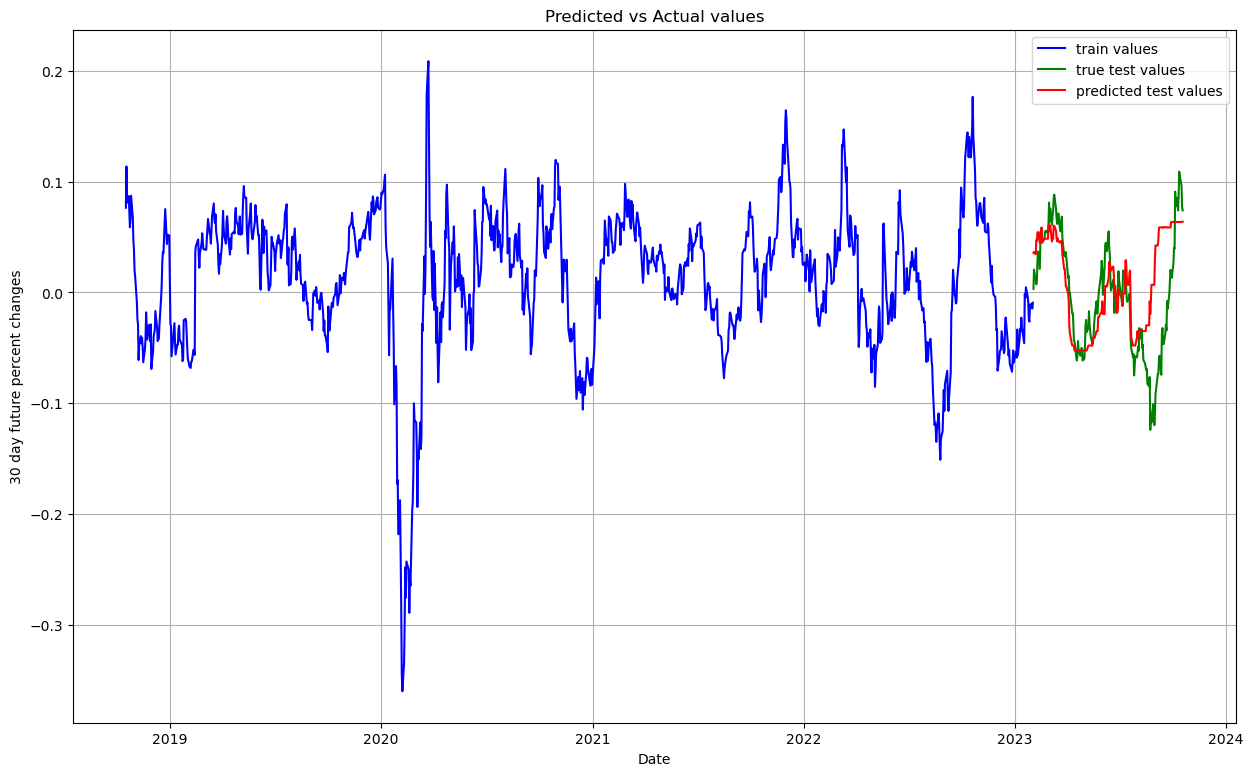

In [23]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(y_test.index)

# Plotting
plt.figure(figsize=(15, 9))

plt.plot(y_train, label='train values', color='blue')
plt.plot(y_test, label='true test values', color='green')
plt.plot(y_pred, label='predicted test values', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel(f'{target_pct_change_period} day future percent changes')
plt.title('Predicted vs Actual values')
plt.legend()
plt.grid(True)
plt.show()

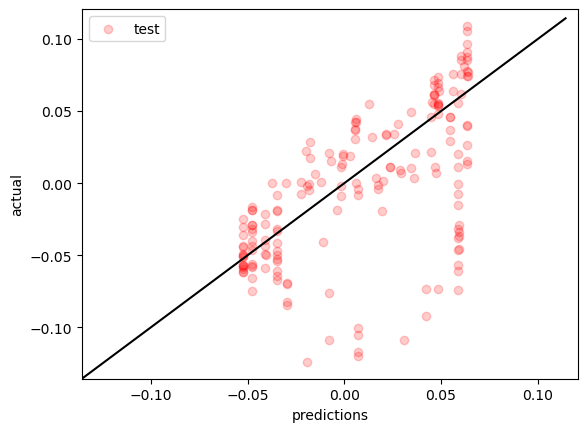

In [24]:
# Scatter the predictions vs the targets with 20% opacity
# plt.scatter(pred_train, y_train, alpha=0.2, color='b', label='train')
plt.scatter(y_pred, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
perfect_line = np.arange(min(xmin, ymin), max(xmax, ymax), 0.01)
plt.plot(perfect_line, perfect_line, c='k')

# Set the same limits on x and y axes
plt.xlim([min(xmin, ymin), max(xmax, ymax)])
plt.ylim([min(xmin, ymin), max(xmax, ymax)])

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

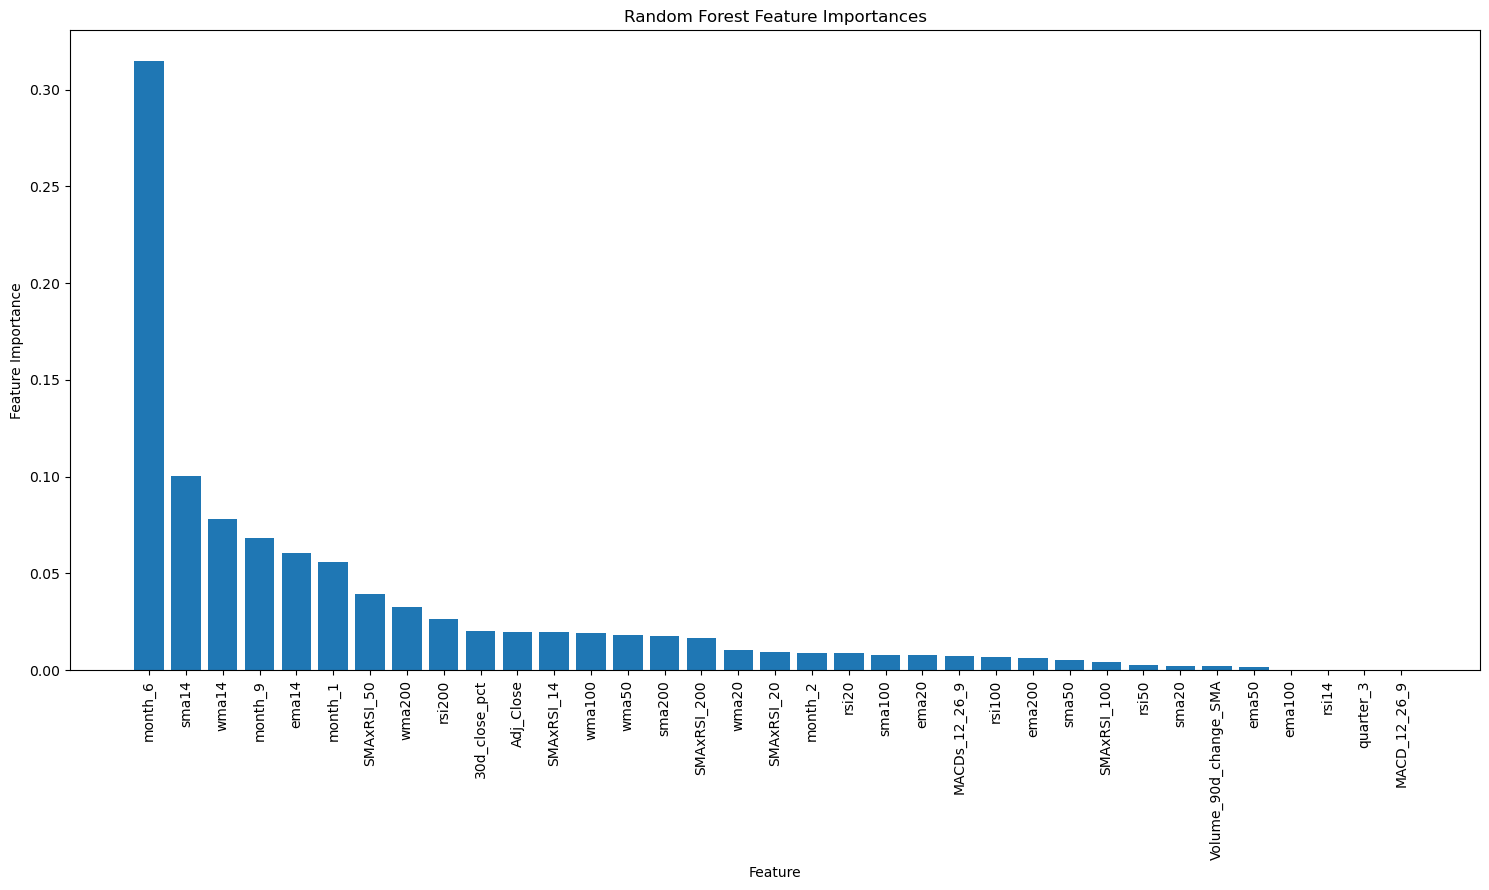

In [25]:
# Get feature importances from the trained Random Forest model
feature_importances = best_model.named_steps['rf'].feature_importances_

feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [26]:
X.columns

Index(['Adj_Close', 'Volume', '30d_close_pct', 'sma14', 'rsi14', 'SMAxRSI_14',
       'sma20', 'rsi20', 'SMAxRSI_20', 'sma50', 'rsi50', 'SMAxRSI_50',
       'sma100', 'rsi100', 'SMAxRSI_100', 'sma200', 'rsi200', 'SMAxRSI_200',
       'ema14', 'ema20', 'ema50', 'ema100', 'ema200', 'wma14', 'wma20',
       'wma50', 'wma100', 'wma200', 'Volume_1d_change',
       'Volume_10d_change_SMA', 'Volume_30d_change_SMA',
       'Volume_60d_change_SMA', 'Volume_90d_change_SMA', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'Log_Volume', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'quarter_1', 'quarter_2',
       'quarter_3'],
      dtype='object')

In [27]:
with mlflow.start_run():

    # Log parameters
    mlflow.log_param("ticker", ticker)
    mlflow.log_param("scaling_method", "StandardScaler" if isinstance(scaler, StandardScaler) else "MinMaxScaler")
    mlflow.log_param("start_date", start_date)
    mlflow.log_param("target_variable", target)
    mlflow.log_param("features", features_to_scale)
    mlflow.log_param("categorical_features", categorical_features)
    mlflow.log_param("hyperparameters", grid_search.best_params_)

    # Log metrics
    mlflow.log_metric(f'{refit_metric}', score)

     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Model info", "Random Forest Regressor")

    # Infer the model signature
    signature = infer_signature(X_train, best_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="random_forest_regressor",
        signature=signature,
        input_example=X_train,
        registered_model_name=f'RFR_{refit_metric}',
    )

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\mlflow\models\signature.py:214: UserWarning: Hint: Inferred schema contains integer